# A fuzzy model for cancer risk prediction
_María Camila Vásquez Correa_

## Necessary packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
import skfuzzy as fuzz

# Matplotlib
%matplotlib inline

# NumPy
np.set_printoptions(suppress=True)

# Cancer risk

### Input

`Quality of the habits` $\in \mathbb{Z} \cap [0, 10]$

`Age` $\in \mathbb{Z} \cap [0, 90]$

`Quality of the genetic heritage` $\in \mathbb{Z} \cap [0, 10]$

In [3]:
habits = 10
age = 75
heritage = 3

###  Domain

In [4]:
# Inputs
x_habits = np.linspace(start=0, stop=10, num=500)
x_age = np.linspace(start=0, stop=90, num=500)
x_heritage = np.linspace(start=0, stop=10, num=500)

# Output
x_risk = np.linspace(start=0, stop=100, num=500)

### Membership functions

In [5]:
# 68–95–99.7 rule
three_sd = 3

def gauss_parameters(mean, zero_value):
    sigma = np.abs(zero_value - mean) / three_sd
    return mean, sigma

def sigmoid_parameters(x, a, b):
    c = -np.log((1 - a) / a) / (x - b)
    return b, c

#### Habits

In [6]:
# Poor
habits_lo = fuzz.trapmf(x=x_habits, abcd=[0, 0, 2, 4])

# Medium
mean, sigma = gauss_parameters(mean=5, zero_value=8)
habits_md = fuzz.gaussmf(x=x_habits, mean=mean, sigma=sigma)

# Good
habits_hi = fuzz.trapmf(x=x_habits, abcd=[6, 8, 10, 10])

#### Age

In [7]:
# Young
b, c = sigmoid_parameters(x=40, a=0.005, b=30)
age_lo = fuzz.sigmf(x=x_age, b=b, c=c)

# Medium
mean, sigma = gauss_parameters(mean=50, zero_value=4)
age_md = fuzz.gaussmf(x=x_age, mean=mean, sigma=sigma)

# Old
b, c = sigmoid_parameters(x=50, a=0.005, b=70)
age_hi = fuzz.sigmf(x=x_age, b=b, c=c)

##### Heritage

In [8]:
# Poor
b, c = sigmoid_parameters(x=5, a=0.005, b=3)
heritage_lo = fuzz.sigmf(x=x_heritage, b=b, c=c)

# Medium
mean, sigma = gauss_parameters(mean=5, zero_value=8)
heritage_md = fuzz.gaussmf(x=x_heritage, mean=mean, sigma=sigma)

# Good
b, c = sigmoid_parameters(x=5, a=0.005, b=7)
heritage_hi = fuzz.sigmf(x=x_heritage, b=b, c=c)

##### Risk of cancer

In [9]:
# Low
b, c = sigmoid_parameters(x=50, a=0.005, b=30)
risk_lo = fuzz.sigmf(x=x_risk, b=b, c=c)

# Medium
mean, sigma = gauss_parameters(mean=50, zero_value=20)
risk_md = fuzz.gaussmf(x=x_risk, mean=mean, sigma=sigma)

# High
b, c = sigmoid_parameters(x=50, a=0.005, b=70)
risk_hi = fuzz.sigmf(x=x_risk, b=b, c=c)

### Utils

In [10]:
def adjust_plot(plt, axes):
    # Turn off top and right axes
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

    # Adjust spacing between subplots
    plt.tight_layout()

### Fuzzy sets

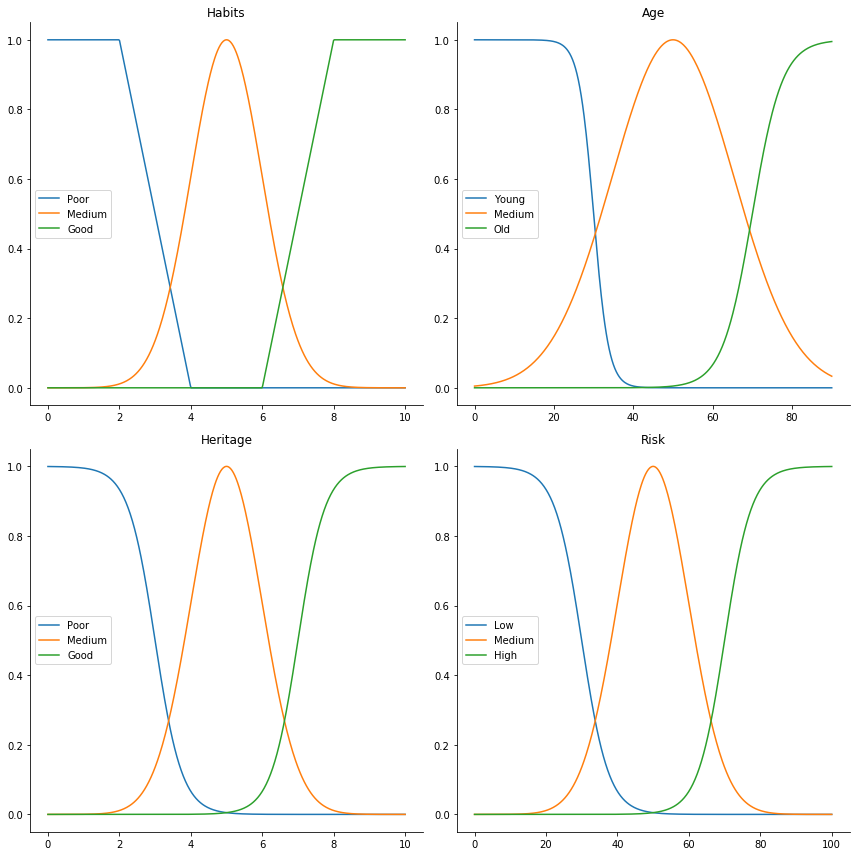

In [11]:
# Create a figure and a set of subplots
fig_size = 12
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(fig_size, fig_size))
axes = axes.flatten()

# Habits
axes[0].plot(x_habits, habits_lo, 'C0')
axes[0].plot(x_habits, habits_md, 'C1')
axes[0].plot(x_habits, habits_hi, 'C2')
axes[0].set_title('Habits')
axes[0].legend(['Poor', 'Medium', 'Good'], loc='center left')

# Age
axes[1].plot(x_age, age_lo, 'C0')
axes[1].plot(x_age, age_md, 'C1')
axes[1].plot(x_age, age_hi, 'C2')
axes[1].set_title('Age')
axes[1].legend(['Young', 'Medium', 'Old'], loc='center left')

# Stress
axes[2].plot(x_heritage, heritage_lo, 'C0')
axes[2].plot(x_heritage, heritage_md, 'C1')
axes[2].plot(x_heritage, heritage_hi, 'C2')
axes[2].set_title('Heritage')
axes[2].legend(['Poor', 'Medium', 'Good'], loc='center left')

# Grade
axes[3].plot(x_risk, risk_lo, 'C0')
axes[3].plot(x_risk, risk_md, 'C1')
axes[3].plot(x_risk, risk_hi, 'C2')
axes[3].set_title('Risk')
axes[3].legend(['Low', 'Medium', 'High'], loc='center left')

adjust_plot(plt, axes)

### Activation of the fuzzy membership functions

In [12]:
# Arguments
domain = [x_habits, x_heritage, x_age]

membership_functions = np.array([
    [habits_lo, habits_md, habits_hi],    
    [heritage_lo, heritage_md, heritage_hi],
    [age_lo, age_md, age_hi]
])

inputs = [habits, heritage, age]

In [13]:
# Activation
n = len(domain)
activation = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        activation[i, j] = fuzz.interp_membership(x=domain[i], xmf=membership_functions[i, j], xx=inputs[i])

print(np.round(activation, 2))

[[0.   0.   1.  ]
 [0.5  0.14 0.  ]
 [0.   0.26 0.79]]


### Decision rules

One line per rule. Each line has the following structure:

    [Category Level] and/or [Category Level] and/or [Category Level] then [Risk Level]

An example:

    [Habits Poor] and [Heritage Poor] and [Age Medium] then [Risk Medium]

In [14]:
# Decision rules
decision_rules = '''
[Habits Poor] and [Heritage Poor] and [Age Low] then [Risk Medium]
[Habits Poor] and [Heritage Poor] and [Age Medium] then [Risk Medium]
[Habits Poor] and [Heritage Poor] and [Age High] then [Risk High]
[Habits Poor] and [Heritage Medium] and [Age Low] then [Risk Low]
[Habits Poor] and [Heritage Medium] and [Age Medium] then [Risk Medium]
[Habits Poor] and [Heritage Medium] and [Age High] then [Risk High]
[Habits Poor] and [Heritage High] and [Age Low] then [Risk Low]
[Habits Poor] and [Heritage High] and [Age Medium] then [Risk Low]
[Habits Poor] and [Heritage High] and [Age High] then [Risk Medium]
[Habits Medium] and [Heritage Poor] and [Age Low] then [Risk Medium]
[Habits Medium] and [Heritage Poor] and [Age Medium] then [Risk High]
[Habits Medium] and [Heritage Poor] and [Age High] then [Risk High]
[Habits Medium] and [Heritage Medium] and [Age Low] then [Risk Low]
[Habits Medium] and [Heritage Medium] and [Age Medium] then [Risk Medium]
[Habits Medium] and [Heritage Medium] and [Age High] then [Risk High]
[Habits Medium] and [Heritage High] and [Age Low] then [Risk Low]
[Habits Medium] and [Heritage High] and [Age Medium] then [Risk Low]
[Habits Medium] and [Heritage High] and [Age High] then [Risk Medium]
[Habits High] and [Heritage Poor] and [Age Low] then [Risk Medium]
[Habits High] and [Heritage Poor] and [Age Medium] then [Risk Medium]
[Habits High] and [Heritage Poor] and [Age High] then [Risk Medium]
[Habits High] and [Heritage Medium] and [Age Low] then [Risk Low]
[Habits High] and [Heritage Medium] and [Age Medium] then [Risk Low]
[Habits High] and [Heritage Medium] and [Age High] then [Risk Medium]
[Habits High] and [Heritage High] and [Age Low] then [Risk Low]
[Habits High] and [Heritage High] and [Age Medium] then [Risk Low]
[Habits High] and [Heritage High] and [Age High] then [Risk Low]
'''

# String
decision_rules = decision_rules.splitlines()
decision_rules = [s for s in decision_rules if len(s) > 0]
decision_rules = [re.findall(r'[\w]+', s) for s in decision_rules]
decision_rules = np.vectorize(str.lower)(decision_rules)

In [15]:
# Dictionaries
categories = {'habits': 0, 'heritage': 1, 'age': 2}
levels = {'low': 0, 'poor': 0, 'medium': 1, 'high': 2}

# Risk
risk = {'low': 0, 'medium': 1, 'high': 2}

# Operators
operators = ['and', 'or']

In [16]:
# Operator precedence: Not, And, Or
def process_rule(rule, activation):
    n_activations = 3
    # Activations
    activations = np.zeros((n_activations,))
    for i in range(n_activations):
        category, level, _ = rule[(i * 3):((i + 1) * 3)]
        activations[i] = activation[categories[category], levels[level]]
    # Operators
    op_1, op_2 = rule[2], rule[5]
    assert op_1 in operators and op_2 in operators
    # Active rule
    if op_1 == op_2:
        if op_1 == 'and':
            #active_rule = activations.min()
            active_rule = activations.prod()
        else:  # 'or'
            active_rule = activations.max()
    else:
        a, b, c = activations
        if op_1 == 'and':  # (a and b) or c
            active_rule = np.maximum(np.minimum(a, b), c)
        else:  # a or (b and c)
            active_rule = np.maximum(a, np.minimum(b, c))        
    # active_rule
    return active_rule

### Active rules

In [17]:
active_rules = [process_rule(rule, activation) for rule in decision_rules]
active_rules = np.array(active_rules)

In [18]:
print(np.round(active_rules.reshape(3, 9), 4))

[[0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.1324 0.3949 0.     0.0358 0.1069 0.     0.     0.    ]]


### Risk activations

In [19]:
# Risk activations
risk_activations = []

# Grades
risk_sets = [risk_lo, risk_md, risk_hi]

for i, rule in enumerate(decision_rules):
    # Get consequent
    consequent = risk_sets[risk[rule[-1]]]
    # Risk activation
    risk_activations += [np.fmin(active_rules[i], consequent)]

In [20]:
# How many decisions rules are activated?
threshold = 0.02

n_activated = np.sum([1 for elem in [elem.max() for elem in risk_activations] if elem > threshold])

Decision rules with an activation lower than the `threshold` are not plot in the following cell, but they are taken into consideration for the final result.

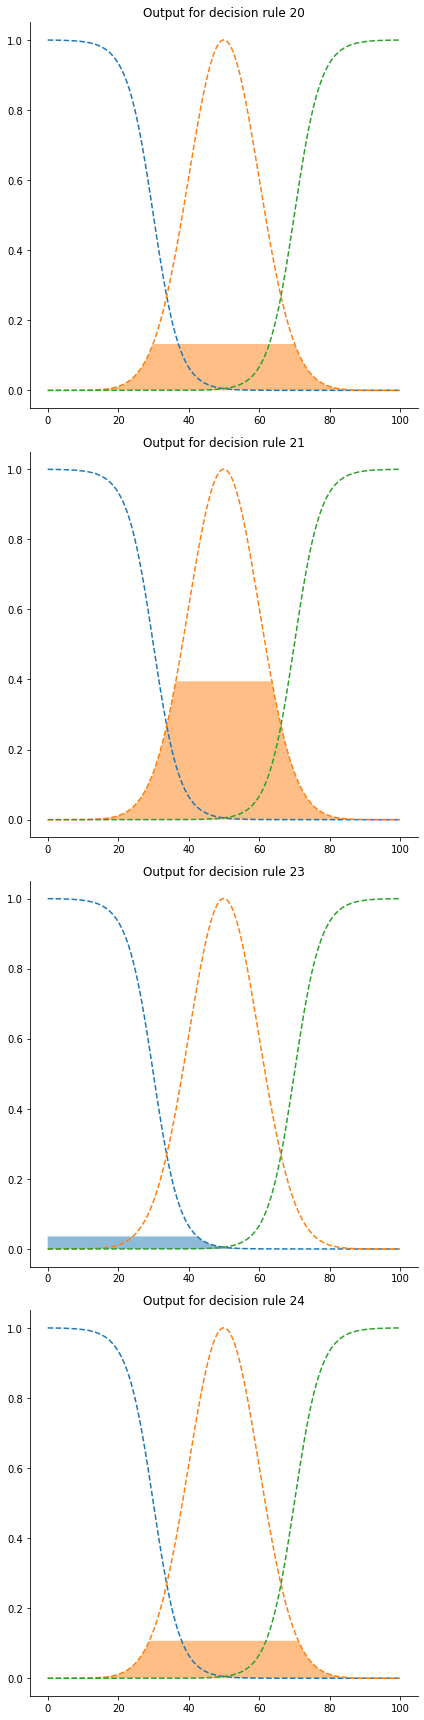

In [21]:
# Initialize
risk_bottom = np.zeros_like(x_risk)

if n_activated > 0:
    # Create a figure and a set of subplots
    fig_size = 6
    fig, axes = plt.subplots(nrows=n_activated, figsize=(fig_size, fig_size * n_activated))
    if n_activated == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    row = 0

    for i, risk_activation in enumerate(risk_activations):
        if risk_activation.max() > threshold:
            # Color
            c = 'C{}'.format(risk[decision_rules[i][-1]])
            # Fill region
            axes[row].fill_between(x_risk, risk_bottom, risk_activation, facecolor=c, alpha=0.5)
            # Fuzzy sets
            for j, a_set in enumerate([risk_lo, risk_md, risk_hi]):
                axes[row].plot(x_risk, a_set, color='C{}'.format(j), linestyle='--')
            # Title
            title = 'Output for decision rule {}'.format(str(i + 1).zfill(2))
            axes[row].set_title(title)
            # Update row
            row += 1

adjust_plot(plt, axes)

### Rule aggregation and Defuzzification

Aggregation method `maximum`

Defuzzification methods to be used:

* `mean of maximum`
* `Centroid of area`
* `Bisector of area`

In [22]:
# Aggregate all output membership functions
aggregated = np.zeros(risk_activations[0].shape)

# Get color for the rule with the largest activation
max_index = None
max_value = 0

for i, risk_activation in enumerate(risk_activations):
    risk_max = risk_activation.max()
    # Update maximum value
    if max_value < risk_max:
        max_index = i
        max_value = risk_max
    aggregated = np.fmax(aggregated, risk_activation)

In [23]:
# Defuzzify result
final_risk = fuzz.defuzz(x_risk, aggregated, 'mom')
#final_risk = fuzz.defuzz(x_risk, aggregated, 'centroid')
#final_risk = fuzz.defuzz(x_risk, aggregated, 'bisector')
final_risk_activation = fuzz.interp_membership(x_risk, aggregated, final_risk)

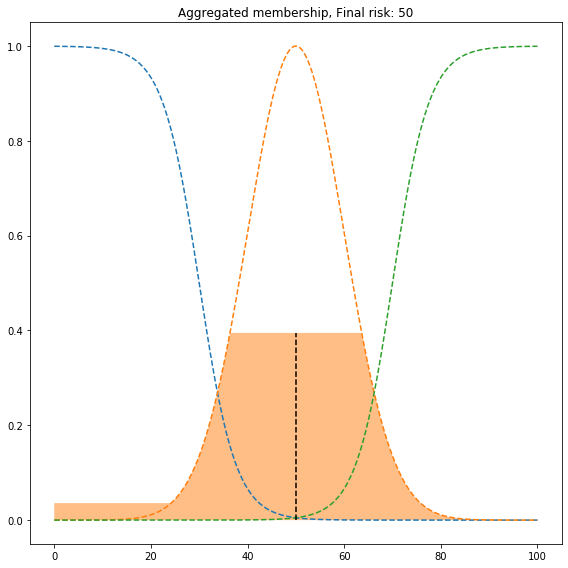

In [24]:
# Create a figure and a subplot
fig_size = 8
fig, ax = plt.subplots(figsize=(fig_size, fig_size))


# Fuzzy sets
for i, a_set in enumerate([risk_lo, risk_md, risk_hi]):
    ax.plot(x_risk, a_set, color='C{}'.format(i), linestyle='--')

# Aggregated membership
c = 'C{}'.format(risk[decision_rules[max_index][-1]])
ax.fill_between(x_risk, risk_bottom, aggregated, facecolor=c, alpha=0.5)

# Final risk
ax.plot([final_risk, final_risk], [0, final_risk_activation], 'k--')

# Title
rounded_risk = int(np.round(final_risk))
title = 'Aggregated membership, Final risk: {}'.format(rounded_risk)
ax.set_title(title)

adjust_plot(plt, axes)

In [25]:
if rounded_risk < 30:
    msg = 'You are doing great, Keep it up!'
elif rounded_risk < 60:
    msg = 'You are not in immediate danger,'
elif rounded_risk < 80:
    msg = 'You could be doing much better, '
else:
    msg = 'You need to see a doctor ASAP'

print('{} Your risk of cancer is {}.'.format(msg, rounded_risk))

You are not in immediate danger, Your risk of cancer is 50.


### Surfaces of the rules

In [26]:
import skfuzzy.control as ctrl

In [27]:
a = ctrl.Antecedent(x_age, 'age')
he = ctrl.Antecedent(x_heritage, 'heritage')
ha = ctrl.Antecedent(x_habits, 'habits')
ris = ctrl.Consequent(x_risk, 'risk')

In [28]:
names = ['lo', 'md','hi']
a.automf(names = names)
ha.automf(names = names)
he.automf(names = names)
ris.automf(names = names)

In [29]:
rule0 = ctrl.Rule(antecedent=((ha['lo'] & he['lo'] & a['lo']) |
                              (ha['lo'] & he['lo'] & a['md']) |
                              (ha['lo'] & he['md'] & a['hi']) |
                              (ha['lo'] & he['hi'] & a['hi']) |
                              (ha['md'] & he['lo'] & a['lo']) |
                              (ha['md'] & he['md'] & a['md']) |
                              (ha['md'] & he['hi'] & a['hi']) |
                              (ha['hi'] & he['lo'] & a['lo']) |
                              (ha['hi'] & he['lo'] & a['md']) |
                              (ha['hi'] & he['lo'] & a['hi']) |
                              (ha['hi'] & he['md'] & a['hi'])),
                  consequent=ris['md'], label='risk md')

rule1 = ctrl.Rule(antecedent=((ha['lo'] & he['lo'] & a['hi']) |
                              (ha['lo'] & he['md'] & a['hi']) |
                              (ha['md'] & he['lo'] & a['md']) |
                              (ha['md'] & he['lo'] & a['hi']) |
                              (ha['md'] & he['md'] & a['hi'])),
                  consequent=ris['hi'], label='risk high')

rule2 = ctrl.Rule(antecedent=((ha['lo'] & he['md'] & a['lo']) |
                              (ha['lo'] & he['hi'] & a['lo']) |
                              (ha['lo'] & he['hi'] & a['md']) |
                              (ha['md'] & he['md'] & a['lo']) |
                              (ha['md'] & he['hi'] & a['lo']) |
                              (ha['md'] & he['hi'] & a['md']) |
                              (ha['hi'] & he['md'] & a['lo']) |
                              (ha['hi'] & he['md'] & a['md']) |
                              (ha['hi'] & he['hi'] & a['lo']) |
                              (ha['hi'] & he['hi'] & a['md']) |
                              (ha['hi'] & he['hi'] & a['hi'])),
                  consequent=ris['lo'], label='risk low')

In [30]:
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2])
sim = ctrl.ControlSystemSimulation(system, flush_after_run=21 * 21 + 1)

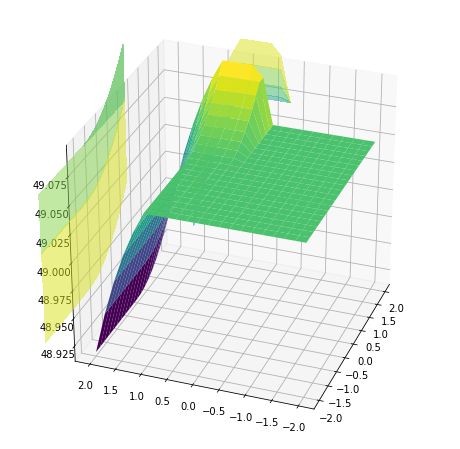

In [46]:
# We can simulate at higher resolution with full accuracy
upsampled = np.linspace(-2, 2, 21)
x, y = np.meshgrid(upsampled, upsampled)
z = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(21):
    for j in range(21):
        sim.input['age'] = x[i, j]
        sim.input['habits'] = y[i, j]
        sim.input['heritage'] = 1
        sim.compute()
        z[i, j] = sim.output['risk']

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)
